In [1]:
import math
import torch
import numpy as np
import pandas as pd
import scipy.sparse as sp
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from LightGCN import LightGCN
from RecommenderTrainer import *
from MovieDataProcessor import *
from sklearn.linear_model import LogisticRegression
from scipy.stats import spearmanr, pearsonr
import RecommenderCAV
from RecommenderCAV import *

In [ ]:
# download dataset
# url = "https://files.grouplens.org/datasets/movielens/ml-1m.zip"
# !wget -q {url} -O ml-1m.zip
# !unzip -q ml-1m.zip

# Set the directory for the dataset
data_path = "../hw1/ml-1m/ratings.dat"
movies_path = "../hw1/ml-1m/movies.dat"
users_path = "../hw1/ml-1m/users.dat"

# Load and preprocess data
processor = MovieDataProcessor(data_path, movies_path, users_path)
processor.load_data()

/Users/malangtian/Documents/StudyMaterials/Courses/stat992_s25/hw2/MovieDataProcessor.py:206: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


In [3]:
EMBEDDING_DIM = 64
NUM_LAYERS = 3
LEARNING_RATE = 0.01

# Define and train LightGCN model
model = LightGCN(
    num_users=processor.num_users,
    num_items=processor.num_items,
    embedding_dim=EMBEDDING_DIM,
    n_layers=NUM_LAYERS,
    user_feat_dim=processor.user_features.shape[1],
    item_feat_dim=processor.item_features.shape[1]
)

trainer = RecommenderTrainer(model, 
                             processor, 
                             learning_rate=LEARNING_RATE)
trainer.train(epochs=5)
trainer.save_model("MovieLens_LightGCN.pth")

Epoch 1/5, Loss: -6724194.0000
Epoch 2/5, Loss: -10868969.0000
Epoch 3/5, Loss: -16090782.0000
Epoch 4/5, Loss: -22315990.0000
Epoch 5/5, Loss: -29451304.0000


In [ ]:
print(processor.item_features.sum(axis=0))

tensor([ 343.,  143.,  105.,   44.,   68.,  471.,  283.,  114., 1200.,  251.,
         276., 1603.,  503.,  106.,   68.,  211.,  127.,  492.])


In [27]:
# Find the CAV for Comedy
from sklearn.decomposition import PCA
import importlib
import RecommenderCAV
importlib.reload(RecommenderCAV)
from RecommenderCAV import *
import seaborn as sns

CAV = RecommenderCAV(processor=processor, model=model)
Comedy_cav = CAV.train_cav("Comedy")
Horror_cav = CAV.train_cav("Horror")
Thriller_cav = CAV.train_cav("Thriller")
Drama_cav = CAV.train_cav("Drama")

concept_names = ["Comedy", "Horror", "Thriller", "Drama"]
cav_vectors = np.array([Comedy_cav, Horror_cav, Thriller_cav, Drama_cav])

pca = PCA(n_components=2)
cav_2d = pca.fit_transform(cav_vectors)



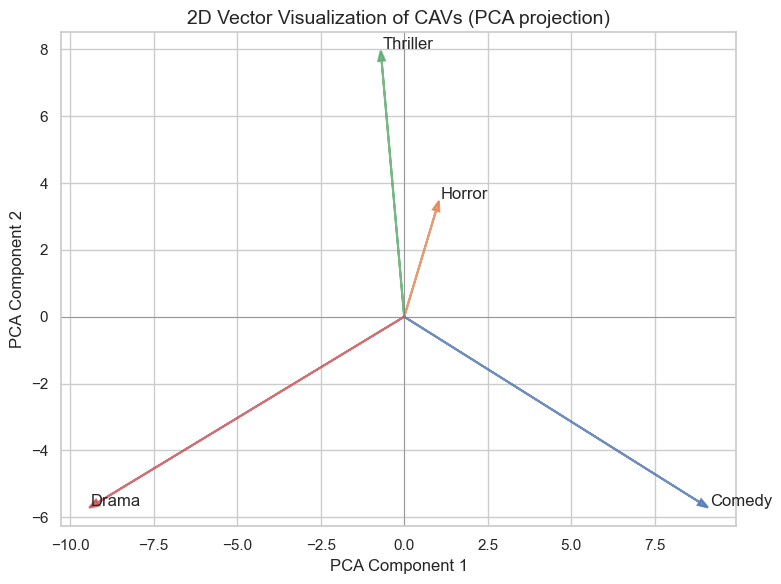

In [ ]:
# Visualizing CAVS

plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")

# Plot origin
origin = np.array([0, 0])

# Draw arrows from origin to each cav vector
for i, name in enumerate(concept_names):
    vec = cav_2d[i]
    plt.arrow(origin[0], origin[1], vec[0], vec[1],
              head_width=0.2, length_includes_head=True, color='C'+str(i), alpha=0.8, linewidth=1.5)
    plt.text(vec[0] + 0.05, vec[1] + 0.05, name, fontsize=12)

plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)

plt.title("2D Vector Visualization of CAVs (PCA projection)", fontsize=14)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [44]:
user_proj_socres = model.final_user_embedding @ Comedy_cav
user_proj_socres.shape

torch.Size([6040])

In [52]:
# Compute user projections for comedy

user_proj_socres = model.final_user_embedding @ Comedy_cav

# Compute avergae ratings for comedy
genre_idx = processor.genre_mapping["Comedy"]
item_feature_matrix = processor.item_features.numpy()
is_concept = item_feature_matrix[:, genre_idx] == 1

user_ratings = {}
for u, i, r in processor.data[['user', 'item', 'rating']].values.tolist():
    if is_concept[i]:
        user_ratings.setdefault(u, []).append(r)
user_avg_comedy_ratings = {u: np.mean(r) for u, r in user_ratings.items()}
user_avg_comedy_ratings = np.array([user_avg_comedy_ratings.get(i, 0) for i in range(processor.num_users)])
user_avg_comedy_ratings.shape

(6040,)

In [56]:
# Compute correlation between user projections and average ratings
spearman_corr, _ = spearmanr(user_proj_socres, user_avg_comedy_ratings)
pearson_corr, _ = pearsonr(user_proj_socres, user_avg_comedy_ratings)
print(f"Spearman correlation: {spearman_corr}")
print(f"Pearson correlation: {pearson_corr}")    

Spearman correlation: 0.012676125633523638
Pearson correlation: 0.015573437636557731


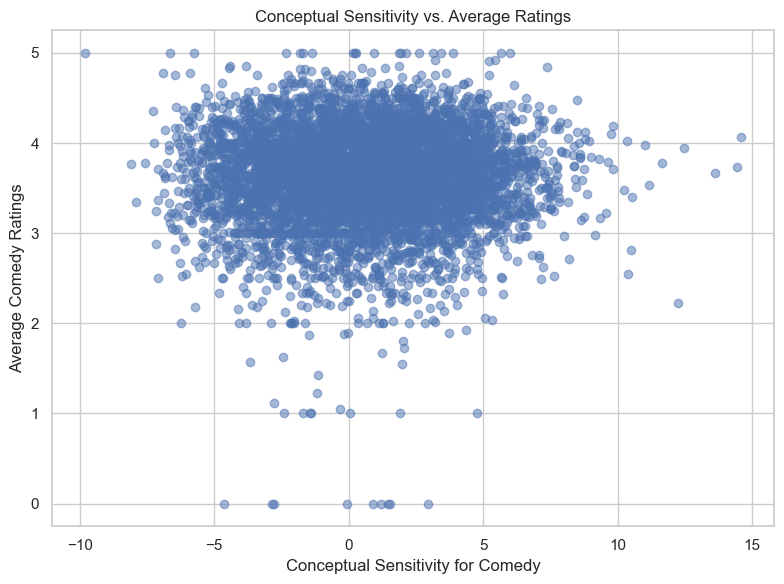

In [60]:
# Scatter plot of user projections and average ratings
plt.figure(figsize=(8, 6))
plt.scatter(user_proj_socres, user_avg_comedy_ratings, alpha=0.5)
plt.title("Conceptual Sensitivity vs. Average Ratings")
plt.xlabel("Conceptual Sensitivity for Comedy")
plt.ylabel("Average Comedy Ratings")
plt.grid(True)
plt.tight_layout()
plt.show()


In [58]:
user_proj_socres_horror = model.final_user_embedding @ Horror_cav

genre_idx = processor.genre_mapping["Horror"]
item_feature_matrix = processor.item_features.numpy()
is_concept = item_feature_matrix[:, genre_idx] == 1

user_ratings = {}
for u, i, r in processor.data[['user', 'item', 'rating']].values.tolist():
    if is_concept[i]:
        user_ratings.setdefault(u, []).append(r)
user_avg_horror_ratings = {u: np.mean(r) for u, r in user_ratings.items()}
user_avg_horror_ratings = np.array([user_avg_horror_ratings.get(i, 0) for i in range(processor.num_users)])
user_avg_horror_ratings.shape

(6040,)

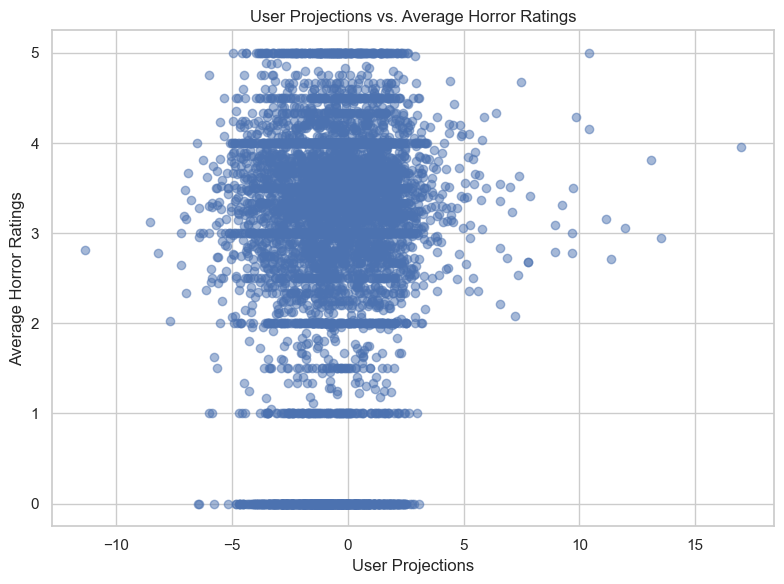

In [59]:
plt.figure(figsize=(8, 6))
plt.scatter(user_proj_socres_horror, user_avg_horror_ratings, alpha=0.5)
plt.title("User Projections vs. Average Horror Ratings")
plt.xlabel("User Projections")
plt.ylabel("Average Horror Ratings")
plt.grid(True)
plt.tight_layout()
